# Uneployment rate in different areas in Denmark


> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

Import your data, either through an API or manually, and load it. 

First off, we want to imprt the Api we should use. 

In [55]:
from dstapi import DstApi

We can now take our desired table, AUL01. This table contains data of full-time unemployed by area, benefit type, unemployment insurance fund, age and gender.

In [56]:
unemp = DstApi('AUL01') 

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

To start off, we would like a look at the data available in our table

In [57]:
tabsum = unemp.tablesummary(language='en')
display(tabsum)

Table AUL01: Full-time unemployed persons by region, type of benefits, unemployment insurance fund, age, sex and time
Last update: 2023-04-14T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,117,000,All Denmark,997,Abroad,False
1,YDELSESTYPE,5,TOT,Gross unemployment,AKT,Activation of persons on social assistance (pr...,False
2,AKASSE,47,TOT,Total,45,Ikke forsikrede,False
3,ALDER,10,TOT,"Age, total",6099,60 year and over,False
4,KØN,3,TOT,Total,K,Women,False
5,Tid,16,2007,2007,2022,2022,True


We will now take a closer look, at the available values for a each variable, before actually choosing 
which variables we would like to use in our analysis.


In [58]:
 for variable in tabsum['variable name']:
    print(variable+':')
    display(unemp.variable_levels(variable, language='en'))

OMRÅDE:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,101,Copenhagen
4,147,Frederiksberg
...,...,...
112,787,Thisted
113,820,Vesthimmerlands
114,851,Aalborg
115,998,Unknown municipality


YDELSESTYPE:


,id,text
0,TOT,Gross unemployment
1,LDP,Net unemployed recipients of unemployment bene...
2,LKT,Net unemployed recipients of social assistance
3,ADP,Activation of persons on unemployment benefits
4,AKT,Activation of persons on social assistance (pr...


AKASSE:


,id,text
0,TOT,Total
1,48,Akademikernes (fra 1. juli 2013 inkl. ingeniører)
2,46,Din Faglige A-kasse (fra 1. januar 2021 inkl. ...
3,05,Børne- og Ungdomspædagoger (BUPL-A)
4,06,Din Sundhedsfaglige A-kasse (DSA)
5,40,Det Faglige Hus A-kasse
6,44,Fag og Arbejde (FOA)
7,43,Faglig Fælles a-kasse (3F)
8,11,A-kassen Frie (fra 1. januar 2020 inkl. DANA)
9,13,Funktionærer og Tjenestemænd (FTF-A)


ALDER:


,id,text
0,TOT,"Age, total"
1,16-24,16-24 years
2,25-29,25-29 years
3,30-34,30-34 years
4,35-39,35-39 years
5,40-44,40-44 years
6,45-49,45-49 years
7,50-54,50-54 years
8,55-59,55-59 years
9,6099,60 year and over


KØN:


,id,text
0,TOT,Total
1,M,Men
2,K,Women


Tid:


,id,text
0,2007,2007
1,2008,2008
2,2009,2009
3,2010,2010
4,2011,2011
5,2012,2012
6,2013,2013
7,2014,2014
8,2015,2015
9,2016,2016


Now we would like to define a param dictionary. 

We use this param dictonary to detailing the data we want. 
We would like to look the unemployment rate in different areas in Denmark, while also looking at the different 
unemployment insurance funds (A-kasse) and their unemployment rates. 
We therefore would like to take out the data of the sex, age. 
We use would like the variable "ydelsestype" but only want to use Gross unemployment (TOT).

In [59]:
#We start off by defining a template for our param dictionary
params = unemp._define_base_params(language='en')
params

{'table': 'aul01',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['*']},
  {'code': 'YDELSESTYPE', 'values': ['*']},
  {'code': 'AKASSE', 'values': ['*']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'KØN', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

We now use the above to define which of the variables that we want to keep.


In [60]:
params = {'table': 'aul01',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['*']},
  {'code': 'YDELSESTYPE', 'values': ['TOT']},
  {'code': 'AKASSE', 'values': ['*']},
  {'code': 'ALDER', 'values': ['TOT']},
  {'code': 'KØN', 'values': ['TOT']},
  {'code': 'Tid', 'values': ['*']}]}

We are now ready to load our data from the dst database, by using the api that utilizes the data we sepcified in the param dictionary. 

In [61]:
unemp_api = unemp.get_data(params=params)
unemp_api.head(5)


,OMRÅDE,YDELSESTYPE,AKASSE,ALDER,KØN,TID,INDHOLD
0,Province Byen København,Gross unemployment,Handels- og Kontorfunktionærer (HK),"Age, total",Total,2018,1220
1,Province Byen København,Gross unemployment,Kristelig a-kasse,"Age, total",Total,2018,1001
2,Province Byen København,Gross unemployment,Ledere,"Age, total",Total,2018,392
3,Province Byen København,Gross unemployment,Lærere (DLF-A),"Age, total",Total,2018,258
4,Province Byen København,Gross unemployment,Magistre (MA),"Age, total",Total,2018,1772


We now want to clean our data a bit. 

As we are only using the Gross employment, we would like to remove this from the output. 
Moreover we want to take out both age "alder" and sex "køn" as we have defined that we use total in both of these,
so they do not add any valuable information to our output. 

To do this we use the ... 

In [62]:
drop_values = ['YDELSESTYPE', 'ALDER', 'KØN']
print(drop_values)

unemp_api.drop(drop_values , axis=1, inplace=True)
unemp_api.head(5)


['YDELSESTYPE', 'ALDER', 'KØN']


,OMRÅDE,AKASSE,TID,INDHOLD
0,Province Byen København,Handels- og Kontorfunktionærer (HK),2018,1220
1,Province Byen København,Kristelig a-kasse,2018,1001
2,Province Byen København,Ledere,2018,392
3,Province Byen København,Lærere (DLF-A),2018,258
4,Province Byen København,Magistre (MA),2018,1772


We now would like to make a table showing differnet descriptive statistics

In [63]:
#We now show the 'OMRÅDE' All Denmark of unemployed ('INDHOLD') for each year in the serie
unique_areas = unemp_api['AKASSE'].unique()
print(unique_areas)

['Handels- og Kontorfunktionærer (HK)' 'Kristelig a-kasse' 'Ledere'
 'Lærere (DLF-A)' 'Magistre (MA)' 'Metalarbejdere'
 'Fødevareforbundet (NNF)' 'Selvstændige (DANA) (- dec. 2019)'
 'Selvstændige Erhvervsdrivende (ASE)' 'Socialpædagoger (SLA)' 'Teknikere'
 'Økonomer (CA)' 'Det Faglige Hus A-kasse'
 'Journalistik, Kommunikation og Sprog'
 'Akademikernes (fra 1. juli 2013 inkl. ingeniører)'
 'Min akasse (jan. 2017 - inkl. Funktionærer og Servicefag)'
 'Ikke forsikrede'
 'Din Faglige A-kasse (fra 1. januar 2021 inkl. Byggefagenes a-kasse og El-faget)'
 'Faglig Fælles a-kasse (3F)' 'Fag og Arbejde (FOA)'
 'Min akasse ( - dec. 2014)' 'Total' 'Business ( - dec. 2014)'
 'Børne- og Ungdomspædagoger (BUPL-A)' 'Din Sundhedsfaglige A-kasse (DSA)'
 'El-faget (- dec. 2020)' 'A-kassen Frie (fra 1. januar 2020 inkl. DANA)'
 'Funktionærer og Servicefag ( - dec. 2016)'
 'Funktionærer og Tjenestemænd (FTF-A)'
 'Træ-Industri-Byg (TIB) ( - dec. 2010)' 'Akademikere (AAK) (- juni 2013)'
 'Ingeniører (IAK) 

In [64]:
UnemployedYear = unemp_api[(unemp_api['OMRÅDE'] == 'All Denmark') & (unemp_api['AKASSE'] == 'Total')][['TID', 'INDHOLD']]

print(UnemployedYear)

        TID  INDHOLD
434    2022    75559
3385   2018   107978
11552  2015   122542
11597  2016   112500
11936  2010   163524
13506  2013   153117
17326  2021   105807
23903  2008    73145
30154  2007   101401
31072  2009   130232
35484  2017   116142
40687  2019   103979
43413  2011   159244
48092  2020   131342
48209  2012   161242
50436  2014   133265


**Interactive plot** :

In [65]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

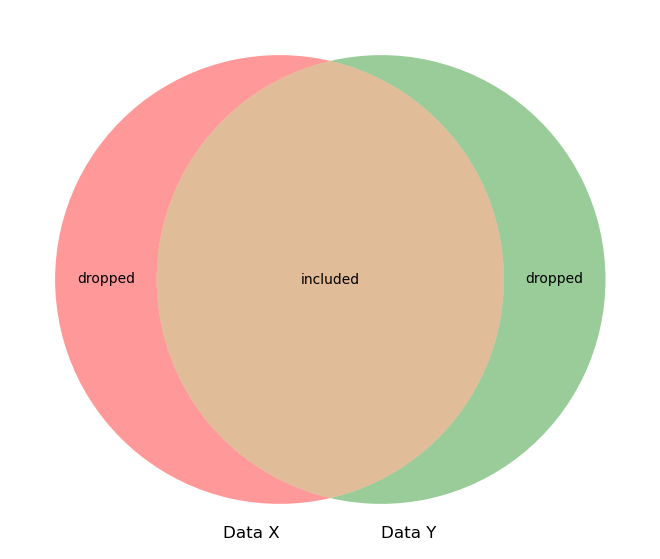

In [66]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.